<a href="https://colab.research.google.com/github/marianelalopezsosa-a11y/PreEntrega2_FastPrompting_FluidezLectora/blob/main/ProyectoFinal_Prompts_Adaptaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generador de Adaptaciones Educativas con IA — Fast Prompting
**Proyecto Final – IA: Generación de Prompts**  
**Fecha:** 2025-09-18 20:18

> Este cuaderno implementa una **POC (proof of concept)** que utiliza **técnicas de fast prompting** para crear materiales inclusivos (texto→texto e indicaciones texto→imagen). Se apoya en un set propio de prompts educativos accesibles.

## Resumen
Este proyecto aborda un problema frecuente en escuelas: **la inversión de tiempo docente para adaptar materiales** a estudiantes con necesidades diversas (dislexia, TDAH, TEA, etc.).  
La solución propuesta es un **kit de prompts** y una rutina de trabajo en Jupyter Notebook que permiten **generar rápidamente** resúmenes accesibles, mapas mentales y evaluaciones gamificadas.  
Se muestran ejemplos funcionales con **texto→texto** (vía API opcional) y **texto→imagen** (vía herramienta externa gratuita), alineados con Neuroeducación y DUA.

## Introducción
### Problema
Docentes y equipos de apoyo **pierden tiempo** generando adaptaciones personalizadas y materiales de estudio accesibles. Esto dificulta la **inclusión** y **la continuidad** del aprendizaje.

### Propuesta de solución
Un **pipeline de fast prompting** con tres casos de uso:
1) **Resumen Adaptado** (texto→texto)  
2) **Mapa Mental** (texto→texto)  
3) **Examen Interactivo Gamificado** (texto→texto)  
+ **Texto→Imagen** opcional: generación de una **infografía o tapa** con herramientas gratuitas (p. ej., NightCafe).

### Viabilidad
- **Tiempo**: implementación en una tarde; prompts listos; copy/paste de imágenes.
- **Recursos**: Notebook + (opcional) API de OpenAI para texto. Para imágenes se usa un generador gratuito (pegar prompt y descargar resultado).
- **Justificación**: estandariza la adaptación y respeta principios de DUA, Neuroeducación y Accesibilidad.

## Objetivos
- Reducir el tiempo de preparación docente con **prompts reutilizables**.
- Mantener **calidad y accesibilidad** en las adaptaciones.
- Mostrar una **POC mínima y funcional** que combine texto→texto e indicaciones texto→imagen.

## Metodología
- **Fast Prompting**: prompts con *placeholders* (`{{...}}`) para completar datos de edad, nivel, fortalezas/desafíos, texto base, etc.
- **Ciclo**: (1) Definir contexto → (2) Renderizar prompt → (3) Generar borrador con IA → (4) Revisar y ajustar → (5) Exportar a aula o papel.
- **Evaluación**: revisión de claridad, cobertura de contenido, adecuación a perfil y tiempo de lectura.

## Herramientas y tecnologías
- **Python + Jupyter** (POC reproducible).
- **(Opcional) OpenAI API** para texto→texto. Si no hay API key, el cuaderno muestra el **prompt** para copiar/pegar en tu asistente favorito.
- **NightCafe/Stable Diffusion** (gratuito) para **texto→imagen** (se pega el prompt, se descarga la imagen y se adjunta aquí).
- **Markdown accesible**: tipografías de palo seco, listas, pictogramas/emojis y tamaños legibles.

In [9]:
from google.colab import userdata

In [10]:
# === Utilidades para la POC ===
import os


def render_prompt(template: str, **kwargs) -> str:
    """Rellena placeholders estilo {{campo}} usando format_map.

    Uso: render_prompt("Hola {nombre}", nombre="Mundo")

    Nota: convertimos {{x}} -> {x} para usar format_map de Python.
    """
    # Pasar de {{campo}} a {campo}
    tmp = template.replace("{{", "{").replace("}}", "}")
    return tmp.format_map(kwargs)

# Llamado opcional a OpenAI (si tienes OPENAI_API_KEY en variables de entorno).
# Si no, el sistema imprime el prompt para que lo copies en tu chat de IA favorito.
def generate_with_openai(system_prompt: str, user_prompt: str, model: str = "gpt-4o-mini") -> None:
    # api_key = os.getenv("OPENAI_API_KEY")
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    api_key = OPENAI_API_KEY
    if not api_key:
        print("== MODO DEMO SIN API ==\nCopia y pega el siguiente PROMPT en tu asistente de IA:\n\n" + user_prompt)
        return
    try:
        from openai import OpenAI
        client = OpenAI(api_key=api_key)
        resp = client.chat.completions.create(
            model=model,
            messages=[
                {"role":"system","content": system_prompt},
                {"role":"user","content": user_prompt}
            ],
            temperature=0.4
        )
        print(resp.choices[0].message.content)
        return resp.choices[0].message.content
    except Exception as e:
        print("Error usando OpenAI:", e)
        print("Recurre al modo DEMO: copia el prompt arriba en tu herramienta de IA.")

## Caso 1 — Resumen Adaptado (Texto→Texto)
**Objetivo:** crear un resumen accesible y bilingüe, con ideas principales y preguntas de reflexión.

In [11]:
prompt_resumen = """**Instrucción al Modelo (Prompt):**

Genera un **resumen adaptado y accesible** del siguiente texto, para
estudiantes de {{edad}} años que cursan {{nivel_educativo}}. El
perfil de la clase incluye:
- Dificultades de Aprendizaje: {{dificultades_aprendizaje}}
- Fortalezas: {{fortalezas_aprendizaje}}

**Requisitos:**
1. Usa lenguaje claro, oraciones cortas y vocabulario frecuente.
2. Destaca ideas principales usando viñetas o listas.
3. Incluye, cuando sea útil, palabras clave en español + su
equivalente en inglés entre paréntesis (p. ej., “célula (cell)”).
4. Utiliza tipografía de palo seco y tamaño ≥ 14 pt en la presentación final.
5. Inserta al final 1 o 2 preguntas reflexivas (pensamiento crítico).
6. (Opcional) Emplea emojis o símbolos para resaltar conceptos clave.
7. Si existe alguna condición específica (dislexia, TDAH, TEA, etc.),
   aplicar recomendaciones obligatorias (letra clara, listas, ejemplos, etc.).

**Texto a resumir:**
{{texto}}

**Salida esperada:**
Un resumen accesible (Markdown) con:
- Título breve
- Puntos principales en viñetas
- Vocabulario bilingüe (cuando sea adecuado)
- 1-2 preguntas de reflexión crítica
- Cumplir adaptaciones según perfil (edad, dificultades, fortalezas)
"""

# === Completar datos del caso de prueba ===
contexto = {
    "edad": 12,
    "nivel_educativo": "6° grado (bilingüe)",
    "dificultades_aprendizaje": "dislexia leve; atención fluctuante",
    "fortalezas_aprendizaje": "comprensión global; memoria verbal inmediata",
    "texto": """La célula es la unidad básica de los seres vivos. Está formada por membrana,
citoplasma y núcleo. Las células realizan funciones como nutrición, relación y reproducción..."""
}

user_prompt = render_prompt(prompt_resumen, **contexto)
system_prompt = "Eres un asistente pedagógico que adapta textos a A2 en progreso con criterios de accesibilidad."

# Ejecuta con OpenAI si tienes API; si no, imprime el prompt para copiar/pegar.
generate_with_openai(system_prompt, user_prompt)

# Resumen sobre la Célula

- **Célula (cell)**: Es la unidad básica de los seres vivos.
- **Partes de la célula**:
  - **Membrana (membrane)**: Cubre la célula y la protege.
  - **Citoplasma (cytoplasm)**: Líquido dentro de la célula donde ocurren muchas actividades.
  - **Núcleo (nucleus)**: Parte que controla las funciones de la célula.
  
- **Funciones de la célula**:
  - **Nutrición (nutrition)**: Obtiene y usa alimentos.
  - **Relación (relation)**: Se comunica con otras células.
  - **Reproducción (reproduction)**: Puede crear nuevas células.

### Preguntas para Reflexionar:
1. ¿Por qué crees que las células son importantes para los seres vivos?
2. ¿Cómo crees que se comunican las células entre sí? 

✨ ¡Recuerda! Cada célula tiene un trabajo muy importante en los seres vivos.


## Caso 2 — Mapa Mental (Texto→Texto)
**Objetivo:** transformar un texto en un mapa mental claro y visualmente guiado.

In [12]:
prompt_mapa = """**Instrucción al Modelo (Prompt):**

Adapta el siguiente texto a un **Mapa Mental** para un estudiante de
{{edad}} años ({{nivel_educativo}}), quien presenta:
- Dificultades: {{dificultades_aprendizaje}}
- Fortalezas: {{fortalezas_aprendizaje}}
- Tipo de Letra: {{case}} (mayúsculas / mayúsculas y minúsculas)
- Texto a adaptar: {{texto}}

**Indicaciones para el Mapa Mental:**
1. Introducción para docentes: utilidad del mapa mental.
2. Secciones en Markdown (###) por idea principal + viñetas de subtemas.
3. Añade emojis para cada rama (📚, 🌟, 🔬, etc.).
4. Colores suaves y tipografía de palo seco (indicado en salida).
5. Oraciones cortas y vocabulario claro.
6. Preguntas para pensamiento crítico (¿por qué?, ¿para qué?).

**Salida esperada:**
Un esquema de mapa mental en Markdown, con título, ramas, sub-ideas, emojis
e indicaciones de estilo (tamaño de letra ≥14, colores suaves).
"""

contexto_mapa = {
    "edad": 12,
    "nivel_educativo": "6° grado (bilingüe)",
    "dificultades_aprendizaje": "dislexia leve",
    "fortalezas_aprendizaje": "comprensión global",
    "case": "MAYÚSCULAS",
    "texto": """Ecosistemas: son sistemas formados por seres vivos y el medio en que viven.
Incluyen biotopo y biocenosis, con relaciones de alimentación, competencia y cooperación..."""
}

user_prompt_mapa = render_prompt(prompt_mapa, **contexto_mapa)
system_prompt_mapa = "Eres un asistente pedagógico que genera mapas mentales accesibles en Markdown."

generate_with_openai(system_prompt_mapa, user_prompt_mapa)

# MAPA MENTAL: ECOSISTEMAS 🌍

### Introducción para docentes:
El mapa mental ayuda a los estudiantes a organizar ideas y comprender mejor los conceptos. Es visual y accesible, ideal para estudiantes con dislexia leve.

---

### ¿QUÉ SON LOS ECOSISTEMAS? 📚
- Sistemas formados por seres vivos y su medio.
- Incluyen:
  - **BIOTOPO**: Lugar físico donde viven los organismos.
  - **BIOCENOSIS**: Conjunto de seres vivos que interactúan.

### RELACIONES EN LOS ECOSISTEMAS 🌟
- **ALIMENTACIÓN**: Cómo se obtienen los nutrientes.
- **COMPETENCIA**: Lucha por recursos (comida, espacio).
- **COOPERACIÓN**: Ayuda entre organismos para sobrevivir.

### IMPORTANCIA DE LOS ECOSISTEMAS 🔬
- Mantienen el equilibrio de la naturaleza.
- Proveen recursos (agua, aire, alimentos).
- Soportan la vida en el planeta.

### PREGUNTAS PARA PENSAMIENTO CRÍTICO ❓
- ¿Por qué son importantes los ecosistemas?
- ¿Para qué necesitamos cuidar el medio ambiente?

---

**Estilo:**
- **Tipografía**: Palo seco
- **Tamaño de let

## Caso 3 — Examen Interactivo Gamificado (Texto→Texto)
**Objetivo:** evaluar con formatos variados, retroalimentación inmediata y tono motivador.

In [13]:
prompt_examen = """**Instrucción al Modelo (Prompt):**

Genera un **Examen Interactivo** basado en el siguiente contenido:
{{texto}}. Está dirigido a un estudiante de {{edad}} años ({{nivel_educativo}}) con:
- Dificultades en el Aprendizaje: {{dificultades_aprendizaje}}
- Fortalezas: {{fortalezas_aprendizaje}}
- Tipografía requerida: {{case}}
- Sección de Evaluación Oral: {{oral}}

**Requisitos:**
1. Preguntas en varios formatos (MCQ, V/F, completar, respuesta breve).
2. Narrativa o misiones + emojis para gamificar.
3. Retroalimentación inmediata por ítem.
4. Indicaciones para evaluación oral (si aplica).
5. Respeta accesibilidad (letra ≥14, consignas claras).
6. Cierra con “Instrucciones para el Docente”.

**Salida esperada:**
Examen en Markdown con consigna inicial, preguntas variadas, retroalimentación,
sección oral (si procede) y guía rápida para docentes.
"""

contexto_examen = {
    "edad": 12,
    "nivel_educativo": "6° grado (bilingüe)",
    "dificultades_aprendizaje": "dislexia leve; atención sostenida variable",
    "fortalezas_aprendizaje": "memoria verbal inmediata",
    "case": "MAYÚSCULAS",
    "oral": "Sí",
    "texto": """Ciclo del Agua: evaporación, condensación, precipitación e infiltración.
La energía solar impulsa el ciclo y permite la circulación del agua en la Tierra..."""
}

user_prompt_examen = render_prompt(prompt_examen, **contexto_examen)
system_prompt_examen = "Eres un asistente pedagógico que diseña evaluaciones accesibles y gamificadas."

generate_with_openai(system_prompt_examen, user_prompt_examen)

# EXAMEN INTERACTIVO: CICLO DEL AGUA 🌊☀️

¡Hola! Bienvenido a tu examen sobre el Ciclo del Agua. Este examen está diseñado para que aprendas mientras te diviertes. Recuerda que puedes tomarte tu tiempo y leer cada pregunta con calma. ¡Buena suerte! 🍀

---

## INSTRUCCIONES:
1. Lee cada pregunta cuidadosamente.
2. Responde seleccionando la opción correcta o completando el espacio en blanco.
3. Al final, tendrás una sección oral donde podrás demostrar lo que aprendiste.
4. Recuerda que puedes usar tus habilidades de memoria verbal para ayudarte.

---

### 1. ¿Cuál de las siguientes opciones describe el proceso de **EVAPORACIÓN**?  
- A) El agua se convierte en vapor.  
- B) El vapor de agua se convierte en nubes.  
- C) El agua cae de las nubes.  
- D) El agua se filtra en el suelo.  

**Retroalimentación:**  
- Si elegiste A: ¡Correcto! La EVAPORACIÓN es cuando el agua se convierte en vapor. ☀️  
- Si elegiste B, C o D: Intenta recordar qué sucede cuando el calor del sol calienta el agu

## Texto→Imagen — Infografía/Tapa
Usando un generador gratuito (**NightCafe**).

> **Prompt:**  
> *"Educational infographic, clean and accessible design, soft colors, sans-serif typography, icons for sections (title, key facts, examples, conclusion), high readability, flat style, minimal, suitable for dyslexia-friendly layouts."*

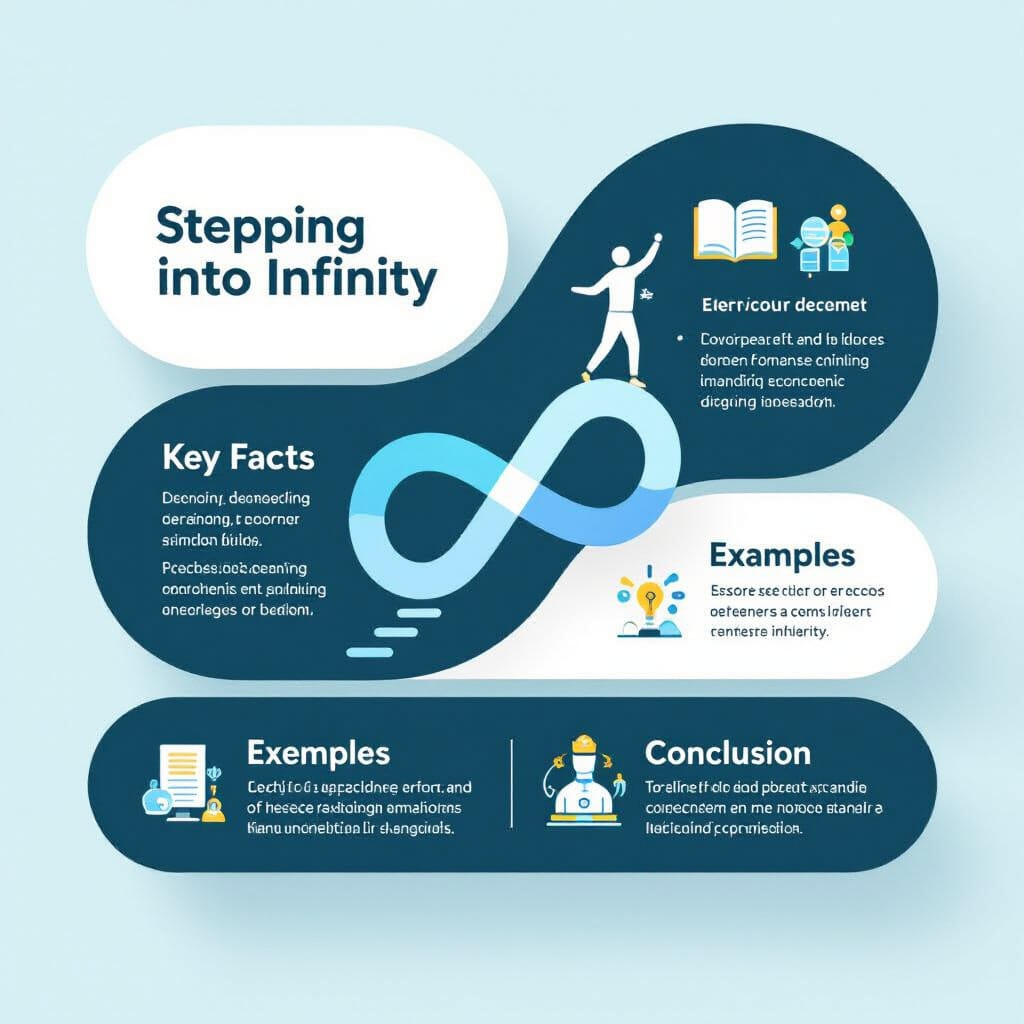

# **Resultados**
## **Resumen Adaptado**:
### Resumen sobre la Célula

- **Célula (cell)**: Es la unidad básica de los seres vivos.
- **Partes de la célula**:
  - **Membrana (membrane)**: Cubre la célula y la protege.
  - **Citoplasma (cytoplasm)**: Líquido dentro de la célula donde ocurren muchas actividades.
  - **Núcleo (nucleus)**: Parte que controla las funciones de la célula.
  
- **Funciones de la célula**:
  - **Nutrición (nutrition)**: Obtiene y usa alimentos.
  - **Relación (relation)**: Se comunica con otras células.
  - **Reproducción (reproduction)**: Puede crear nuevas células.

### Preguntas para Reflexionar:
1. ¿Por qué crees que las células son importantes para los seres vivos?
2. ¿Cómo crees que se comunican las células entre sí?

✨ ¡Recuerda! Cada célula tiene un trabajo muy importante en los seres vivos.

## **Mapa Mental**:

# MAPA MENTAL: ECOSISTEMAS 🌍

### Introducción para docentes:
El mapa mental ayuda a los estudiantes a organizar ideas y comprender mejor los conceptos. Es visual y accesible, ideal para estudiantes con dislexia leve.

---

### ¿QUÉ SON LOS ECOSISTEMAS? 📚
- Sistemas formados por seres vivos y su medio.
- Incluyen:
  - **BIOTOPO**: Lugar físico donde viven los organismos.
  - **BIOCENOSIS**: Conjunto de seres vivos que interactúan.

### RELACIONES EN LOS ECOSISTEMAS 🌟
- **ALIMENTACIÓN**: Cómo se obtienen los nutrientes.
- **COMPETENCIA**: Lucha por recursos (comida, espacio).
- **COOPERACIÓN**: Ayuda entre organismos para sobrevivir.

### IMPORTANCIA DE LOS ECOSISTEMAS 🔬
- Mantienen el equilibrio de la naturaleza.
- Proveen recursos (agua, aire, alimentos).
- Soportan la vida en el planeta.

### PREGUNTAS PARA PENSAMIENTO CRÍTICO ❓
- ¿Por qué son importantes los ecosistemas?
- ¿Para qué necesitamos cuidar el medio ambiente?

---

**Estilo:**
- **Tipografía**: Palo seco
- **Tamaño de letra**: ≥14
- **Colores suaves**: Utilizar tonos pasteles para fondo y texto.

## **Examen Interactivo**:

# EXAMEN INTERACTIVO: CICLO DEL AGUA 🌊☀️

¡Hola! Bienvenido a tu examen sobre el Ciclo del Agua. Este examen está diseñado para que aprendas mientras te diviertes. Recuerda que puedes tomarte tu tiempo y leer cada pregunta con calma. ¡Buena suerte! 🍀

---

## INSTRUCCIONES:
1. Lee cada pregunta cuidadosamente.
2. Responde seleccionando la opción correcta o completando el espacio en blanco.
3. Al final, tendrás una sección oral donde podrás demostrar lo que aprendiste.
4. Recuerda que puedes usar tus habilidades de memoria verbal para ayudarte.

---

### 1. ¿Cuál de las siguientes opciones describe el proceso de **EVAPORACIÓN**?  
- A) El agua se convierte en vapor.  
- B) El vapor de agua se convierte en nubes.  
- C) El agua cae de las nubes.  
- D) El agua se filtra en el suelo.  

**Retroalimentación:**  
- Si elegiste A: ¡Correcto! La EVAPORACIÓN es cuando el agua se convierte en vapor. ☀️  
- Si elegiste B, C o D: Intenta recordar qué sucede cuando el calor del sol calienta el agua. 🌞

---

### 2. Completa la frase:  
La **CONDENSACIÓN** ocurre cuando el vapor de agua se enfría y se convierte en __________.  

**Retroalimentación:**  
- Si escribiste "agua" o "gotas": ¡Bien hecho! La CONDENSACIÓN forma gotas de agua. 💧  
- Si no lo sabías: Piensa en cómo se forma el rocío en la mañana. 🌅

---

### 3. Verdadero o Falso:  
La **PRECIPITACIÓN** es el proceso en el que el agua se infiltra en el suelo.  
- A) Verdadero  
- B) Falso  

**Retroalimentación:**  
- Si elegiste B: ¡Correcto! La PRECIPITACIÓN es cuando el agua cae de las nubes, como lluvia o nieve. ❄️  
- Si elegiste A: Recuerda que la infiltración es un proceso diferente. 🌧️

---

### 4. ¿Qué papel juega la **ENERGÍA SOLAR** en el ciclo del agua?  
- A) No tiene ningún papel.  
- B) Calienta el agua y permite que se evapore.  
- C) Hace que el agua se congele.  
- D) Solo afecta a la tierra.  

**Retroalimentación:**  
- Si elegiste B: ¡Excelente! La ENERGÍA SOLAR es fundamental para el ciclo del agua. ☀️  
- Si elegiste A, C o D: Piensa en cómo el sol calienta el agua en ríos y océanos. 🌊

---

### 5. Misión:  
Imagina que eres una gota de agua en el ciclo del agua. Describe brevemente (3-4 oraciones) qué procesos pasas desde que te evaporas hasta que caes como lluvia.  

**Retroalimentación:**  
- Aquí no hay respuestas incorrectas. Lo importante es que uses tu imaginación y lo que aprendiste. 📝

---

## SECCIÓN ORAL:  
Ahora, quiero que me cuentes sobre el ciclo del agua. Puedes explicar los cuatro procesos (evaporación, condensación, precipitación e infiltración) y cómo la energía solar los impulsa. Tómate tu tiempo y recuerda usar tus palabras. ¡Estoy listo para escucharte! 🎤

---

## INSTRUCCIONES PARA EL DOCENTE:
1. Asegúrate de que el examen sea accesible para el estudiante, utilizando una tipografía clara y un tamaño de letra adecuado (≥14).
2. Proporciona un ambiente tranquilo para la evaluación oral, permitiendo que el estudiante se exprese sin presiones.
3. Ofrece apoyo adicional si es necesario, especialmente en la sección de respuesta breve y oral.
4. Fomenta el uso de la memoria verbal del estudiante para ayudarlo a recordar los conceptos.
5. Recuerda dar retroalimentación positiva y constructiva en cada respuesta.

¡Gracias por tu atención y apoyo! 🌟


## Conclusiones
- Los **prompts reutilizables** permiten acelerar la preparación de materiales inclusivos.
- La **revisión docente** es esencial para asegurar pertinencia y precisión.
- El enfoque es **escalable**: se pueden añadir más prompts (guías de estudio, role-plays, etc.).

## Referencias
- Conjunto de **prompts educativos accesibles** (documento del autor/a).
- Lineamientos de **Neuroeducación** y **DUA** aplicados a adaptaciones.
- Herramientas sugeridas por la cátedra (NightCafe u otras).